In [1]:
import h5torch
import numpy as np
import torch
import pytorch_lightning as pl
import warnings
from pytorch_lightning.callbacks import Callback

/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
celltype_file = "/data/home/natant/Negatives/Data/Encode690/ENCODE_hg38_subset_101bp_celltypes_ATAC_H5/GM12878.h5t"
file = h5torch.File(celltype_file, 'r')
central = file["central"][:]
peak_ix_to_pos = file["1/peak_ix_to_pos"][:]
peak_ix_to_len = file["1/peak_ix_to_len"][:]
peak_ix_to_chr = file["1/peak_ix_to_chr"][:]
prot_names = file["0/prot_names"][:]
prot_mask_ATAC = prot_names== b"ATAC_peak" # filter out the ATAC peaks entry

subset = ["chr1", "chr2", "chr3"] # STILL FILTER OUT THE ATAC PEAKS ENTRY
peak_mask = np.isin(peak_ix_to_chr.astype(str), subset)

In [3]:
prot_names
TF = "CTCF"
prot_mask_TF = file["0/prot_names"][:] == TF.encode()

In [4]:
central.shape

(37, 807457)

In [5]:
(central[prot_mask_ATAC]==1).sum()

np.int64(366600)

In [6]:
ATAC_c = central[prot_mask_ATAC]
TF_c = central[prot_mask_TF]

In [7]:
new_vector = np.full(ATAC_c.shape, 2)  # Initialize with 2
new_vector[(TF_c == 1)] = 1  # Set to 1 where TF_c is 1
new_vector[(ATAC_c == 1) & (TF_c != 2)] = 0  # Set to 0 where ATAC_c is 1 and TF_c is not 2
new_vector[(ATAC_c == 1) & (TF_c == 2)] = 2  # Ensure 2 where ATAC_c is 1 and TF_c is 2

In [8]:
# put everything as 2 (not used)
new_vector = np.full(ATAC_c.shape, 2)
new_vector.shape

(1, 807457)

In [9]:
# set the positives from the TF as positives
new_vector[(TF_c == 1)] = 1  # Set to 1 where TF_c is 1
(new_vector==1).sum()

np.int64(40090)

In [10]:
# if a position is open according to ATAC and it does not overlap with a positive of the TF take it as a negative
new_vector[(ATAC_c == 1) & (TF_c != 2)] = 0 # Set to 0 where ATAC_c is 1 and TF_c is not 2
(new_vector==0).sum()

np.int64(330257)

In [11]:
(new_vector==2).sum()

np.int64(437110)

In [12]:
# this one should not change anything!
new_vector[(ATAC_c == 1) & (TF_c == 2)] = 2  # Ensure 2 where ATAC_c is 1 and TF_c is 2
(new_vector==2).sum()

np.int64(437110)

In [13]:
np.unique(new_vector,return_counts=True)

(array([0, 1, 2]), array([330257,  40090, 437110]))

In [14]:
mask_atac = new_vector != 2
mask_atac = mask_atac.squeeze()

In [15]:
mask_subset = np.isin(peak_ix_to_chr.astype(str), subset) #only take the right (training, val) positions

In [16]:
mask_atac

array([ True,  True,  True, ..., False, False,  True], shape=(807457,))

In [17]:
mask_subset

array([ True,  True,  True, ..., False, False, False], shape=(807457,))

In [18]:
mask = mask_atac & mask_subset
mask.sum()

np.int64(93164)

In [19]:
new_vector[0].squeeze()

array([0, 0, 0, ..., 2, 2, 1], shape=(807457,))

In [20]:
new_vector[0].squeeze()[mask]

array([0, 0, 0, ..., 0, 1, 0], shape=(93164,))

In [21]:
peak_ix_to_pos = file["1/peak_ix_to_pos"][mask]
peak_ix_to_len = file["1/peak_ix_to_len"][mask]
peak_ix_to_chr = file["1/peak_ix_to_chr"][mask]

In [22]:
peak_ix_to_chr

array([b'chr1', b'chr1', b'chr1', ..., b'chr3', b'chr3', b'chr3'],
      shape=(93164,), dtype='|S5')

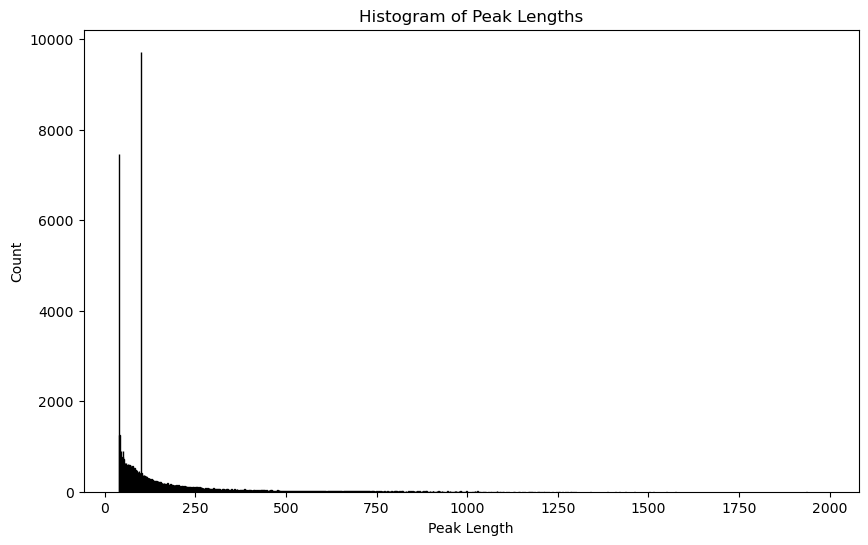

In [23]:
import matplotlib.pyplot as plt

# Get unique values and their counts
unique_lengths, counts = np.unique(peak_ix_to_len, return_counts=True)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_lengths, counts, width=1.0, edgecolor='black')
plt.xlabel('Peak Length')
plt.ylabel('Count')
plt.title('Histogram of Peak Lengths')
plt.show()

In [24]:
from TFBS_negatives.data import HQ_dataset
HQ_dataset = HQ_dataset(file,'CTCF', subset=subset)
print(HQ_dataset.__len__())
print(HQ_dataset.__getitem__(0))
temp_len = HQ_dataset.__len__()
print(HQ_dataset.__getitem__(temp_len-1))

93164
{'0/prot_names': 'CTCF', '1/DNA_regions': [array([2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0,
       0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2,
       1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2,
       2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 0,
       2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 0, 0], dtype=int8)], 'central': [np.int64(0)]}
{'0/prot_names': 'CTCF', '1/DNA_regions': [array([1, 2, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 1, 2, 1, 2, 0, 2, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 0, 2, 0, 2, 2,
       2, 1, 0, 0, 1, 0, 1, 2, 0, 1, 1, 3, 1, 2, 0, 0, 2, 3, 1, 2, 2, 0,
       0, 3, 0, 2, 0, 2, 0, 3, 1, 3, 3, 2, 1, 3, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 2, 1, 1, 0, 2, 0, 3, 1, 3], dtype=int8)], 'central': [np.int64(0)]}


/data/home/natant/Negatives/TFBS_negatives/TFBS_negatives/data.py:346: UserWarning: The handling of sequences with length > 101 is currently a placeholder and must be updated.
  warnings.warn("The handling of sequences with length > 101 is currently a placeholder and must be updated.")
/data/home/natant/Negatives/TFBS_negatives/TFBS_negatives/data.py:342: UserWarning: The handling of sequences with length < 101 is currently a placeholder and must be updated.
  warnings.warn("The handling of sequences with length < 101 is currently a placeholder and must be updated.")


In [25]:
print(HQ_dataset.__getitem__(1009))

{'0/prot_names': 'CTCF', '1/DNA_regions': [array([3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 0, 2, 0, 3, 3, 0,
       0, 3, 3, 3, 2, 0, 2, 0, 3, 3, 3, 1, 3, 2, 1, 1, 2, 0, 0, 3, 0, 1,
       2, 3, 2, 1, 3, 0, 1, 0, 3, 3, 2, 2, 3, 2, 2, 1, 3, 2, 0, 2, 1, 2,
       2, 2, 0, 2, 0, 3, 2, 2, 0, 1, 3, 1, 0, 3, 2, 1, 2, 2, 2, 0, 2, 2,
       1, 1, 2, 1, 3, 1, 2, 0, 3, 2, 1, 1, 1], dtype=int8)], 'central': [np.int64(0)]}


In [26]:
from TFBS_negatives.data import DataModule
file = "/data/home/natant/Negatives/Data/Encode690/ENCODE_hg38_subset_101bp_celltypes_ATAC_H5/A549.h5t"
Dmod = DataModule(file, TF = "CTCF", batch_size=32, neg_mode="shuffled")

/data/home/natant/Negatives/TFBS_negatives/TFBS_negatives/data.py:378: UserWarning: MAKE BETTER CHROM SPLIT AND ALSO INCLUDE THE ALTS!!!
  warnings.warn("MAKE BETTER CHROM SPLIT AND ALSO INCLUDE THE ALTS!!!")


In [27]:
from TFBS_negatives.models import multilabel
model = multilabel(latent_vector_size=1)

In [28]:
import torch
torch.cuda.is_available()

True

In [1]:
import pytorch_lightning as pl
trainer = pl.Trainer(
    max_steps = 5_000_000,
    val_check_interval = 10000,
    limit_val_batches=200, 
    accelerator = "gpu", 
    devices = [6]
)

/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install li

In [ ]:
trainer.fit(model, Dmod)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | loss_function | MultiLabelLoss    | 0      | train
1 | embedding     | Embedding         | 20     | train
2 | DNA_branch    | EnformerConvStack | 52.0 K | train
------------------------------------------------------------
52.0 K    Trainable params
20        Non-trainable params
52.0 K    Total params
0.208     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
ERROR:tornado.general:SEND Error: Host unreachable

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...

Detected KeyboardInterrupt, attempting graceful shutdown ...


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
